In [1]:
import numpy as np
import torch

from astropy import table as astropy_table

import torch_geometric.transforms as ttr

from mptd.reader import get_raw_data
from mptd.simple_message import SimpleMessage
from mptd.data_types import SimTransientData
from mptd.plotter import plot_data, plot_clusters, plot_fits_data
from mptd.clusterer import get_clusters

In [ ]:
import os.path as osp
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")
keys = ["PI", "X", "TIME", "Y"]
raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).long())

plot_data(data.x, (0.1, 0.1), data.y.bool(), keys)


In [ ]:

plot_data(data.x, (0.0, 0.1), data.y.bool(), keys)

In [ ]:
import os.path as osp

filenames = []
# filenames.append(osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ")) # hard example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M1S001MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601PNS003PIEVLF0000.FTZ")) # easy example
# filenames.append(osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ")) # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 10
quantile = 0.99

In [ ]:
raw_datas = []
for filename in filenames:
    raw_datas.append(get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)}))
raw_data = astropy_table.vstack(raw_datas)

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated=data.y.bool()

masked_data, masked_sizes, labels, mask = \
    get_clusters(net_data, distances, model, layers, quantile)

data = data.cpu()
issimulated = issimulated.cpu()

plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data, masked_sizes, issimulated[mask], keys)
plot_clusters(masked_data[:, 1:4], masked_sizes, labels, keys[1:4])
plot_data(data.x, (0.0, 0.5), issimulated, keys)

In [2]:
from main import main
for filename in filenames:
    main(filename, keys, k, layers, quantile)

NameError: name 'filename' is not defined

In [2]:
from sklearn.cluster import DBSCAN

import torch

def my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=1, plot_after = 0):
    elaborated_data = torch.ones_like(net_data.x[:, 0].unsqueeze(-1))
    # issimulated=net_data.y.bool()

    for i in range(layers):
        elaborated_data += model.forward(elaborated_data, net_data.edge_index)#, edge_weight=gaussian_kernel(distances, distances.median()*1000))
        sizes = elaborated_data[:,0]
        # threshold = torch.quantile(sizes,  quantile).item()
        threshold = min(sizes.mean().item(), 0.5)
        mask = sizes >= threshold
        net_data = transform(SimTransientData(x=net_data.x[mask], y= net_data.y[mask]))
        if (i+1)%plot_every == 0 and i >= plot_after:
            plot_data(net_data.x.cpu(), sizes[mask].cpu(), issimulated=net_data.y.cpu().bool(), keys=keys, title=f"iteration {i+1}")
        elaborated_data /= elaborated_data.max()
        elaborated_data = elaborated_data[mask]

    dbscan = DBSCAN(eps=distances.median().item()/2, min_samples=5)  # Adjust parameters according to your data

    masked_data = net_data.cpu()
    masked_sizes = sizes[mask].cpu()

    labels = dbscan.fit_predict(masked_data.x)

    return masked_data, masked_sizes, labels, mask.cpu()

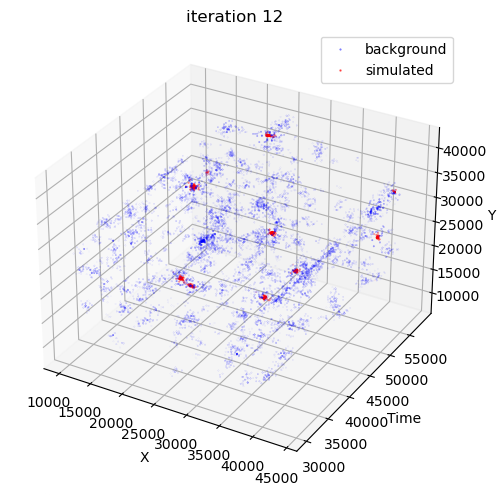

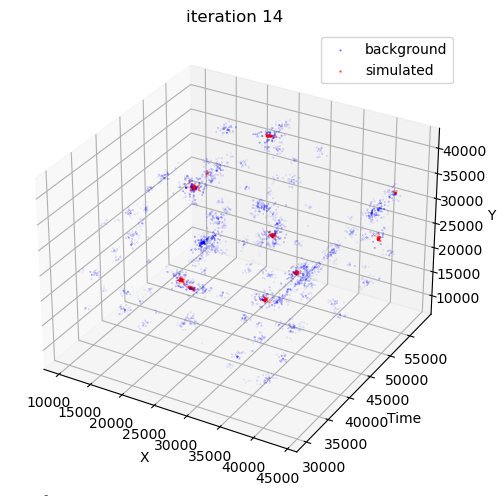

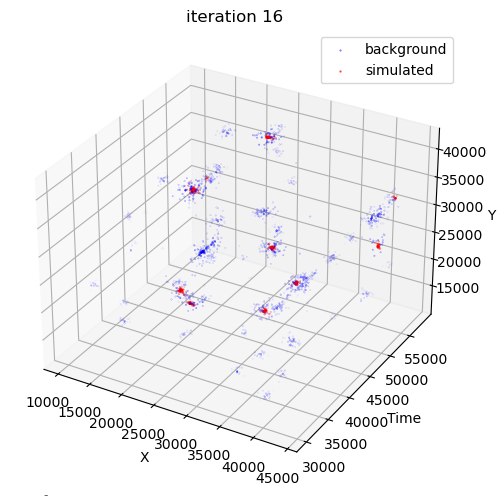

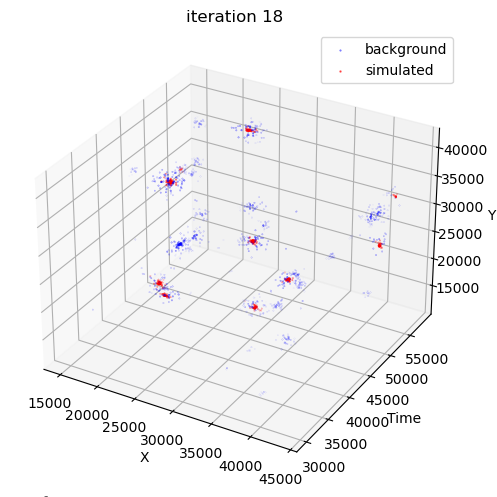

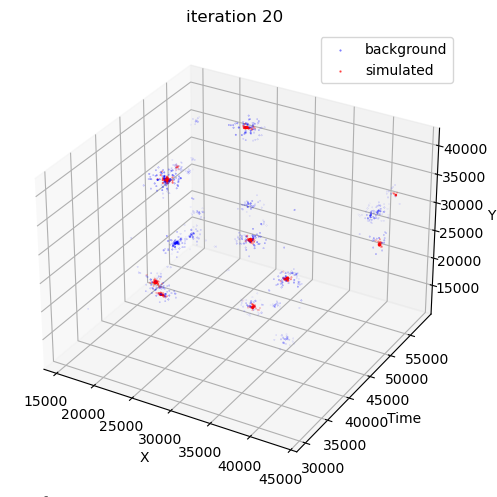

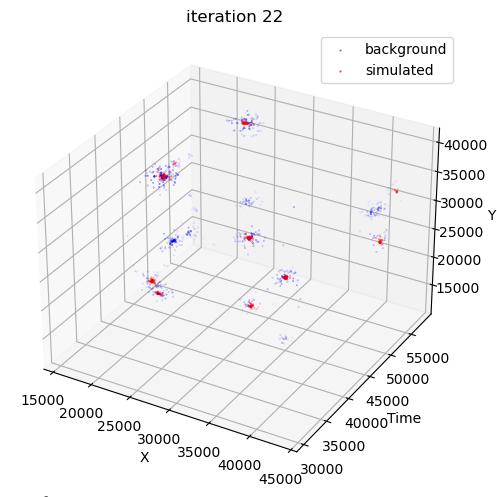

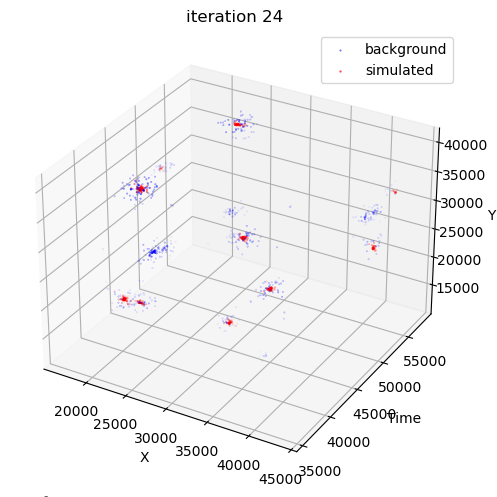

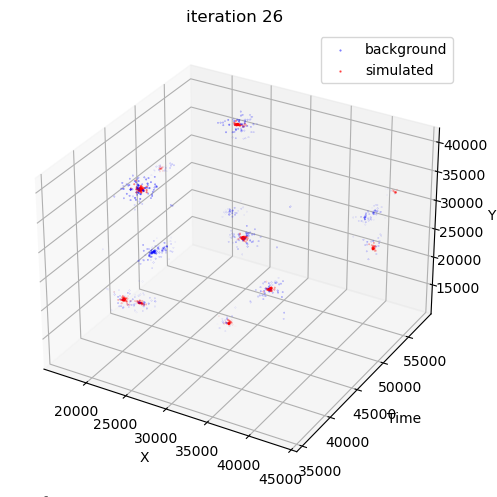

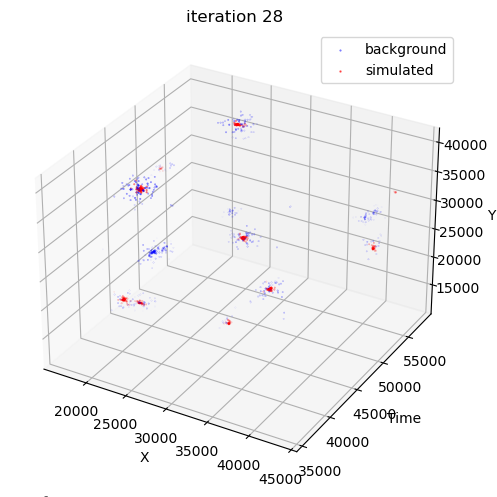

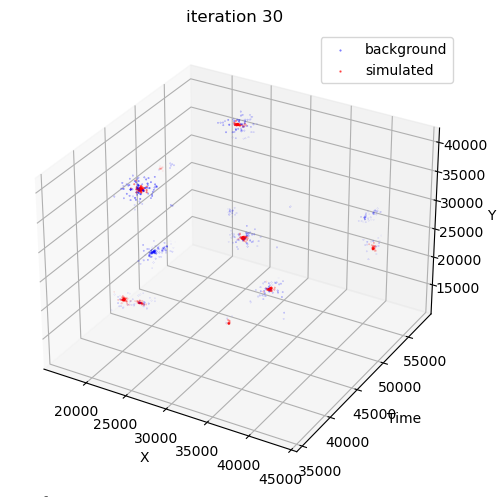

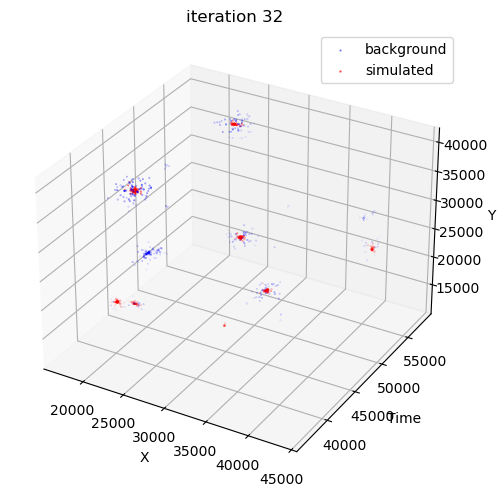

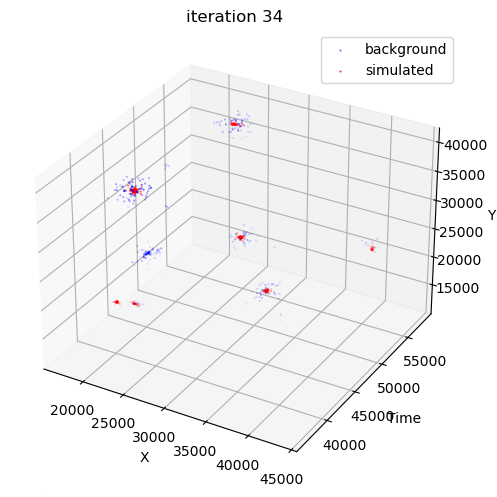

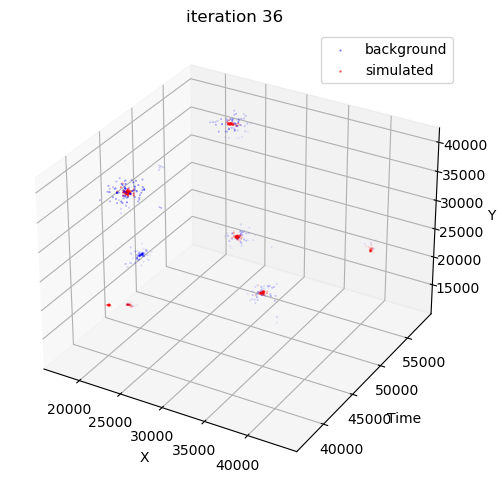

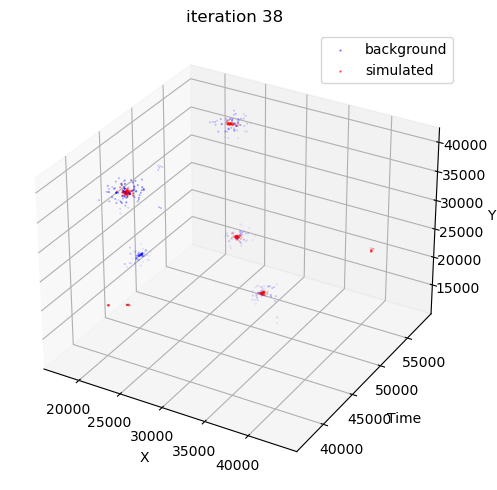

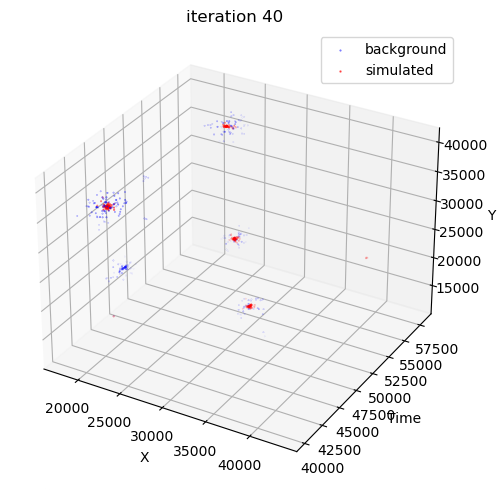

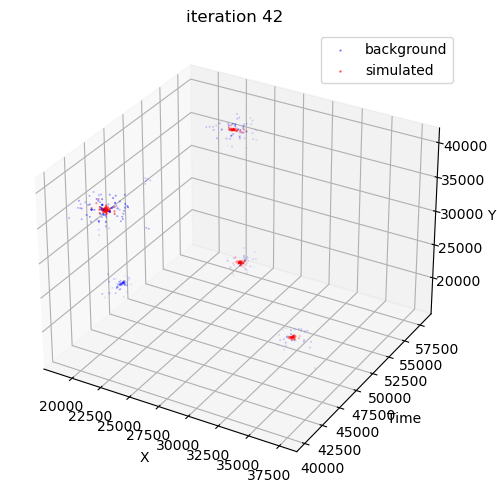

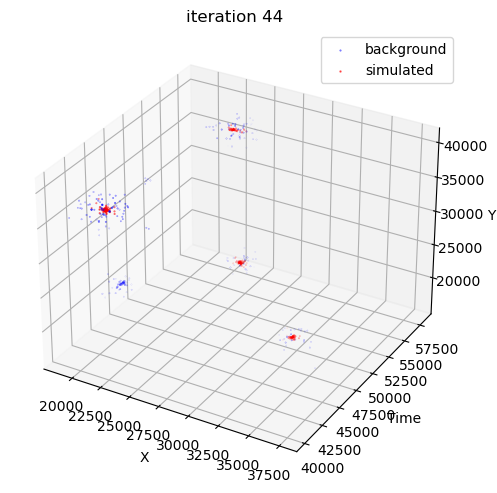

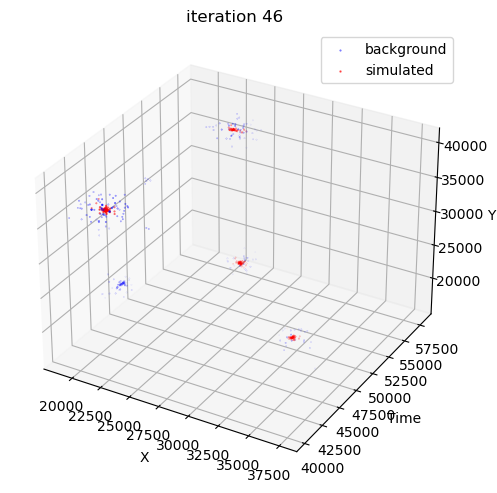

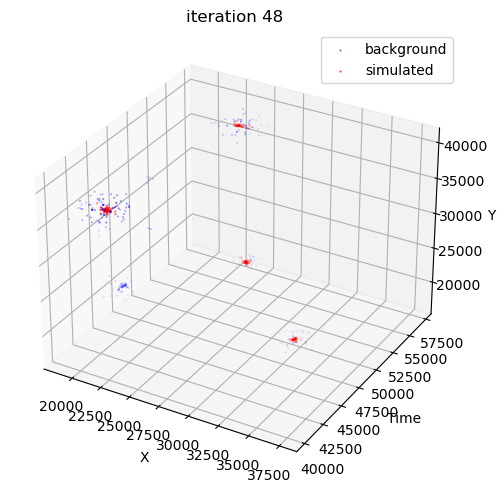

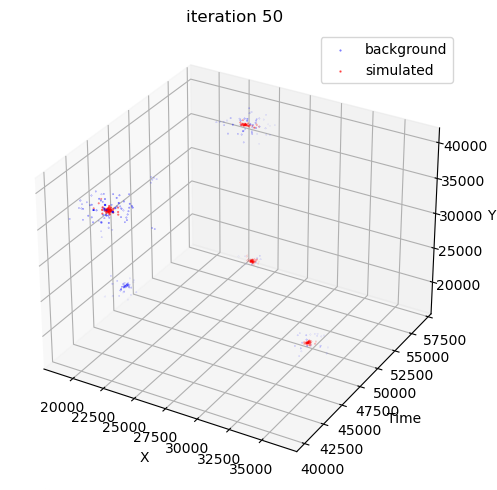

In [3]:
import os.path as osp

# filename = osp.join("test.onD", "Icaro", "raw", "0694730101", "pps", "P0694730101PNS003PIEVLF0000.FTZ") # hard example
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ") # easy example
# filename = osp.join("test.onD", "Icaro", "raw", "0744440301", "pps", "P0744440301M1S001MIEVLF0000.FTZ") # medium example
keys = ["PI", "X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.6

raw_data = get_raw_data(filename=filename, keys=keys, filters={"FLAG": (0,4)})

data = SimTransientData(x = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                        y = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).long()).cuda()

transform = ttr.KNNGraph(k=k, force_undirected=True)

net_data =transform(data)

distances = torch.norm(net_data.x[net_data.edge_index[0]] - net_data.x[net_data.edge_index[1]], dim=1)

model = SimpleMessage()

issimulated = data.y.bool().cpu()

masked_data, masked_sizes, labels, mask = \
    my_get_clusters(net_data, distances, model, layers, quantile, transform, plot_every=2, plot_after=10)

masked_issimulated=masked_data.y.bool()

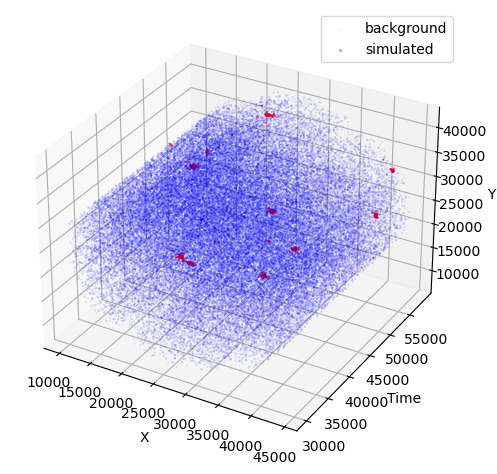

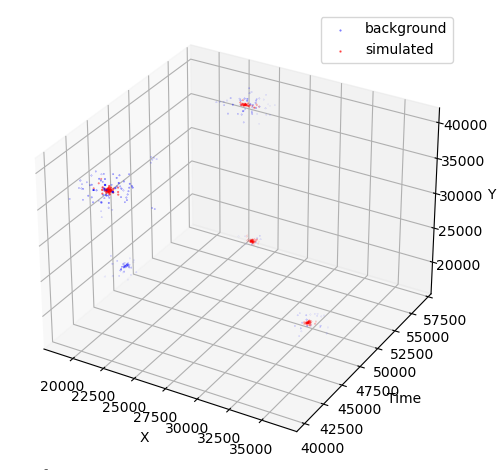

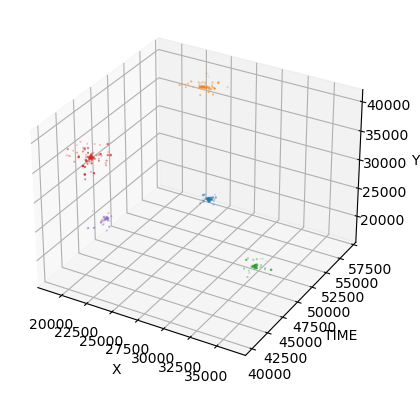

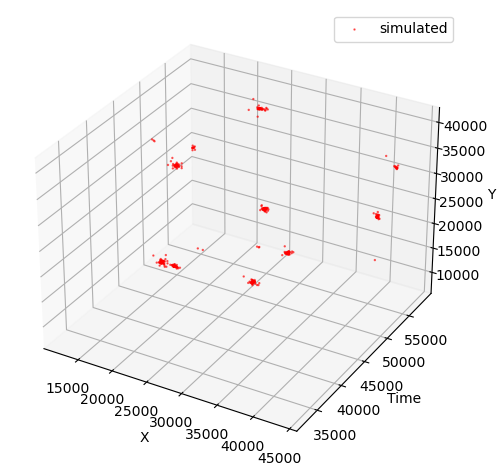

In [4]:

data = data.cpu()
issimulated = issimulated.cpu()

plot_data(data.x, (0.01, 0.5), issimulated, keys)
plot_data(masked_data.x, masked_sizes, masked_issimulated, keys)
plot_clusters(masked_data.x[:, 1:4], masked_sizes, labels, keys[1:4])
plot_data(data.x, (0.0, 0.5), issimulated, keys)